# Lab 1: Sampling and coding basics

This lab aims to get familiar with the basics of audio sampling and of coding audio signals, listening to its effect.

Make sure you understand all the code given and its signal processing task before answering the questions.

Use headphones to listen to the sounds when doing the different exercises.

## Relevant concepts:

### Spectrum
The magnitude spectrum of a sound describes the magnitudes as a function of frequency.

### Spectrogram
A visual way to represent the magnitudes of of different frequencies of a sound over time.

### Sampling Rate
Number of samples of a signal taken every second. It defines the frequency range obtained.

### Bit depth
Number of bits used to represent every sample of a signal. It defines the dynamic rage obtained.

### Resampling
Changing the sampling rate of a signal. It is first important to filter out the frequencies that cannot be represented in the new sampling rate.

### Quantization
Changing the number of bits used to represent every sample of a signal.

### MP3
Formally MPEG-1 Audio Layer III is a coding format for digital audio commonly used on internet applications.

In [5]:
# installations and imports needed for the whole lab
!git clone https://github.com/xserra/audio-coding-materials.git
!pip install pydub
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
from scipy.fft import fft
import IPython.display as ipd
from scipy.io.wavfile import read
from pydub import AudioSegment

fatal: destination path 'audio-coding-materials' already exists and is not an empty directory.


In [2]:
# functions used in the whole lab
def read_sound(file):
  """ read a mono wav sound file, assuming is mono, and convert it to a floating point array
    Args:
      file (str): File name
    Returns:
      sound_array (numpy.array): Array of samples as floating point values between -1 and 1
      sampling_rate (int): Sampling rate
  """
  # read sound file
  sampling_rate, x = read(file)
  # convert to floating point values between -1 and 1, assuming x are 16 bit integers
  sound_array = np.float32(x) / 2**15
  return sound_array, sampling_rate

def display_sound(sound_array, sampling_rate=44100):
  """ Display signal sound_array
    Args:
      sound_array (numpy.array): Array of samples
      sampling_rate (int): Sampling rate
  """
  # plot the waveform of the sound
  plt.figure(0, figsize=(10, 4))
  time_indexes = np.arange(0, sound_array.size/sampling_rate, 1.0/sampling_rate)
  plt.plot(time_indexes, sound_array)
  plt.xlabel('time (seconds)')
  plt.ylabel('amplitude')
  plt.show()
  # play the sound
  ipd.display(ipd.Audio(data=sound_array, rate=sampling_rate))

def display_spectrum(sound_array, sampling_rate=44100):
  """ Display magnitude spectrum of signal sound_array
    Args:
      sound_array (numpy.array): Array of samples
      sampling_rate (int): Sampling rate
  """
  # compute the hanning window
  window = signal.get_window('hann', sound_array.size)
  # compute the spectrum of the windowed input signal
  spectrum = fft(window*sound_array)
  # compute the magnitude spectrum in dB
  magnitude_spectrum = 20*np.log10(abs(spectrum[:spectrum.size//2]))

  # plot the magnitude spectrum
  plt.figure(0, figsize=(10, 5))
  frequency_indexes = np.arange(0, sampling_rate/2, sampling_rate/spectrum.size)
  plt.plot(frequency_indexes, magnitude_spectrum)
  plt.xlabel('frequency (Hz)')
  plt.ylabel('amplitude (dB)')
  plt.show()

def display_spectrogram(sound_array, hop_size=256, fft_size=512, sampling_rate=44100):
  """ Display magnitude spectrogram of signal sound_array
    Args:
      sound_array (numpy.array): Array of samples
      hop_size (int): window hop size
      fft_size (int): Spectrogram fft size
      sampling_rate (int): Sampling rate of sound
  """
  # compute the hanning window
  window = signal.get_window('hann', fft_size)
  # initialize the output spectrogram
  magnitude_spectrogram = []
  sample_index = 0
  # iterate over the input sound computing a sequence of spectra
  while sample_index < sound_array.size-fft_size:
    spectrum = fft(window*sound_array[sample_index:sample_index+fft_size])
    magnitude_spectrum = 20*np.log10(abs(spectrum[:spectrum.size//2]))
    magnitude_spectrogram.append(magnitude_spectrum)
    sample_index += hop_size

  # plot the magnitude sspectrogram
  plt.figure(figsize=(10, 5))
  time_indexes = np.arange(0, sample_index/sampling_rate, hop_size/sampling_rate)
  frequency_indexes = np.arange(0, sampling_rate/2, sampling_rate/fft_size)
  plt.pcolormesh(time_indexes, frequency_indexes, np.transpose(magnitude_spectrogram), shading='nearest', cmap='inferno')
  plt.colorbar(format='%+2.0f dB')
  plt.xlabel('time (seconds)')
  plt.ylabel('frequency (Hz)')
  plt.show()

## Part 1- Reading and plotting an audio file

Read and plot an audio file downloaded from the coursue github repository, synthetic.wav. Listen to the sound and plot its waveform, plot a spectrum of a sound fragment, and plot its spectrogram. For both the spectrum and the spectrogram try different values of the fft_size: 256, 1024, and 2048. Answer the questions given and modify the code to support your answers.

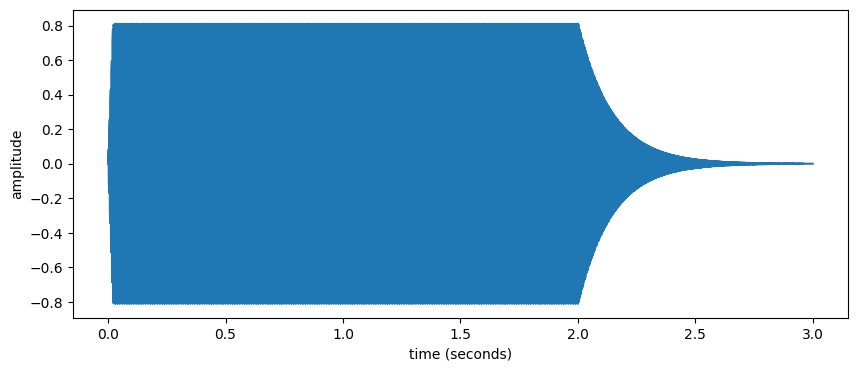

In [6]:
# read and display a sound
sound_array, sampling_rate = read_sound('/content/audio-coding-materials/synthetic.wav')
display_sound(sound_array, sampling_rate)

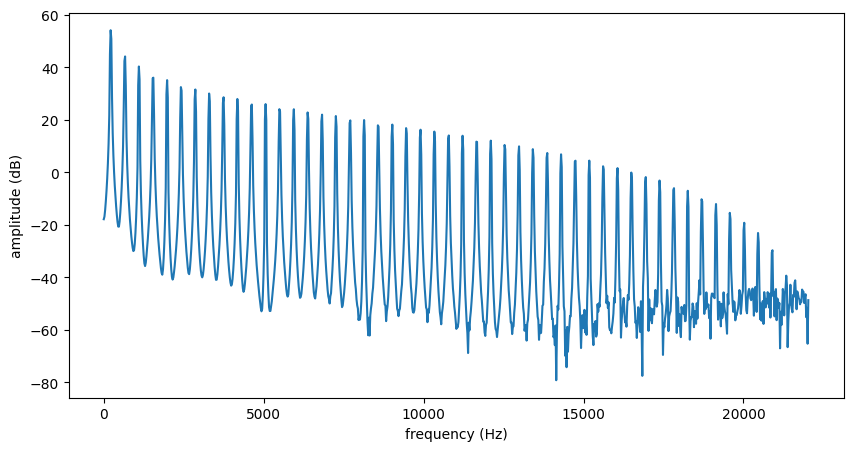

In [7]:
# display spectrum of a stable fragment of sound_array, try different values for fft_size, all being a power of 2
# ex: 256, 1024, 2048
fft_size = 2048
sample_offset = int(1.0 * sampling_rate) # choose the starting sample at 1 second
display_spectrum(sound_array[sample_offset:sample_offset+fft_size], sampling_rate)

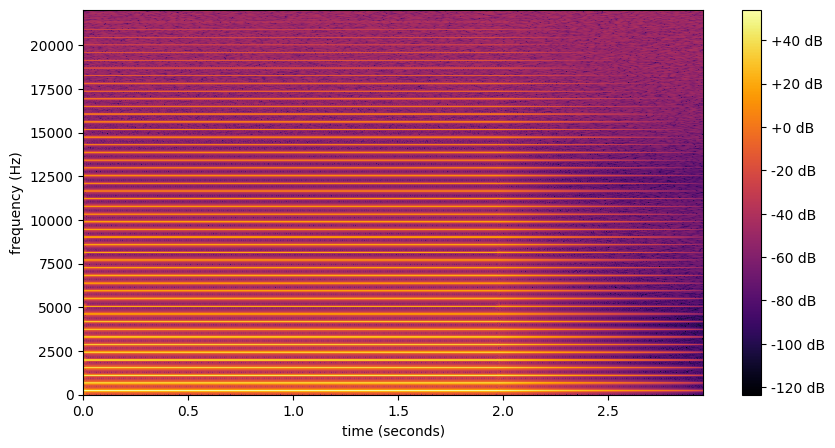

In [8]:
# display spectrogram of x, try different values for fft_size, all being a power of 2
# ex: 256, 1024, 2048
hop_size = 128
fft_size = 2048
display_spectrogram(sound_array, hop_size, fft_size, sampling_rate)

**Questions: (answer them in this text cell)**

1. Explain the effect of the different fft_size values in the spectrum and spectrogram displays. Example values to try: 256, 1024, 2048. Refer to the code and plots given.

2. What is the fundamental frequency, in Hz, of the sound. Explain how you obtained. Modify or add any code and plots above to support your answer.

## Part 2 - Resample sound

Resample (decimate) and change the bits per sample (quantize) a sound signal by different amounts and compare the results. Find the highest compression that still keeps the perceptual qualities of the original sound. Answer the questions given and modify the code as needed.

In [ ]:
def quantize_signal(x, original_bits, target_bits):
  """Quantizes a signal x, assuming it originally had original_bits bits per sample, to target_bits per sample.
  Args:
    x (numpy.array): Array of samples as floating point values between -1 and 1
    original_bits (int): Number of bits of the signal that x represents
    target_bits (int): Number of bits per sample of the output signal
  """
  # Scaling the signal to the range of [0, 2^target_bits - 1]
  x_scaled = (x - np.min(x)) / (np.max(x) - np.min(x)) * (2**target_bits - 1)
  # Quantize by rounding
  x_quantized = np.round(x_scaled)
  # Re-scaling back to the original amplitude range
  x_output = (x_quantized / (2**target_bits - 1)) * (np.max(x) - np.min(x)) + np.min(x)
  return x_output

# change the decimate_factor (dowmnsample the sound) and find the lowest sampling rate for which you do not hear a difference
decimate_factor = 2   # 2 means reducing the sampling rate to half of the original
decimated_sound_array = signal.decimate(sound_array, decimate_factor)
display_sound(decimated_sound_array, sampling_rate/decimate_factor)

# change the number_of_bits of the samples and find the lowest number for which you do not hear a difference
number_of_bits = 8   # 8 means to reduce the number of bits per sample to half of the original, which is 16
quantized_sound_array = quantize_signal(sound_array, 16, number_of_bits)
display_sound(quantized_sound_array, sampling_rate)

# change the decimate_factor (dowmnsample the sound) and the number_of_bits (quantize)
# to find the most compressed signal for which you do not hear a difference
number_of_bits = 8
decimate_factor = 3
decimated_and_quantized_sound_array= quantize_signal(signal.decimate(sound_array, decimate_factor), 16, number_of_bits)
display_sound(decimated_and_quantized_sound_array, sampling_rate/decimate_factor)


**Questions: (answer in this text cell)**

1. What is the biggest decimation for which you do not hear a difference? Change the demination factor in the code and explain the result supporting your answer with any needed plot.

2. What is the biggest quantization for which you do not hear a difference?. Change the number of bits in the code and explain your answer supporting it with any needed plot.

2. What it the highest compression factor you get without losing the perceptual quality of the original sound when performing both a decimation and a quantization?. Explain your answer supporting it with any needed plot.

## Part 3 - Apply audio coding
Compress an audio signal with mp3 and use different bit rates to control the compression. Find the lowest bit rate for which you do not hear a difference. Change the code as needed and answer the questions given.

In [ ]:
# read the audio file using AudioSegment
audio1 = AudioSegment.from_wav('/content/audio-coding-materials/synthetic.wav')
wav_file_size = os.path.getsize('/content/audio-coding-materials/synthetic.wav')
print(f'wav file size: {wav_file_size} bytes')

# change the bit_rate used in the compression, try: 256kbits/s, 192kbits/s, 96kbits/s, 32kbits/s.
# find the lowest bitrate for which you do not hear a difference
bit_rate ="256k"

# compress the sound with mp3
audio1.export('/content/synthetic.mp3', format="mp3", bitrate=bit_rate)

# read the compressed mp3 file
audio2 = AudioSegment.from_mp3('/content/synthetic.mp3')
mp3_file_size = os.path.getsize('/content/synthetic.mp3')
print(f'mp3 file size: {mp3_file_size} bytes')

# display the original and compressed sound
x = np.array(audio1.get_array_of_samples())
y = np.array(audio2.get_array_of_samples())
display_sound(x,audio1.frame_rate)
display_sound(y,audio2.frame_rate)
display_spectrogram(y, 512, 1024, audio2.frame_rate)

**Questions: (answer in this cell)**

1. Explain the perceptual effect of different bit rates in the mp3 coding, 256kbits/s, 192kbits/s, 96kbits/s, 32kbits/s. Use the spectrograms of the original and compressed sounds to suport your explanation. What is the lowest bit rate for which you do not hear a significant difference?

2. Calculate the compression factor obtained by comparing the sizes of the original and the most compressed but good sounding compressed file. Also compute the compression factor by comparing the bit_rate of original sound with the bit_rate of this compresed sound. Any difference? If so, explain the reason.